<a href="https://www.kaggle.com/code/mateusbaldamota/neural-network-dl?scriptVersionId=207658064" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import libraries
Author: Mateus Balda

Paper: https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.707581/full

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

from imblearn.over_sampling import SMOTE

from warnings import filterwarnings
filterwarnings('ignore')

torch.__version__

'2.4.0+cpu'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
np.random.seed(123)
torch.manual_seed(123)

In [5]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')

column = 'Unnamed: 122' # column 122 is nan
df = df.drop(columns=[column])

X = df.iloc[:,8:]
y = df['main.disorder']

X.shape, y.shape

((945, 1140), (945,))

In [6]:
X

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,22.582176,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,17.636528,20.220791,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,12.687296,20.257619,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,21.799254,36.083181,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,17.442777,18.859586,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [7]:
column_names = np.unique(y).tolist()
column_names

['Addictive disorder',
 'Anxiety disorder',
 'Healthy control',
 'Mood disorder',
 'Obsessive compulsive disorder',
 'Schizophrenia',
 'Trauma and stress related disorder']

In [8]:
pd.DataFrame(np.unique(y))

,0
0,Addictive disorder
1,Anxiety disorder
2,Healthy control
3,Mood disorder
4,Obsessive compulsive disorder
5,Schizophrenia
6,Trauma and stress related disorder


In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = y_encoded.astype(np.float32)

In [10]:
pd.DataFrame(y_encoded).value_counts()

0  
3.0    266
0.0    186
6.0    128
5.0    117
1.0    107
2.0     95
4.0     46
Name: count, dtype: int64

In [11]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

In [12]:
pd.DataFrame(y_resampled).value_counts()

0  
0.0    266
1.0    266
2.0    266
3.0    266
4.0    266
5.0    266
6.0    266
Name: count, dtype: int64

In [13]:
pd.DataFrame(X_resampled)

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,22.582176,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,22.876896,21.671704,19.155013,23.623478,23.520776,22.371989,17.096274,12.579030,19.983157,22.660010,...,59.770962,34.746013,31.160429,45.216325,46.857054,16.665933,44.675454,10.727746,55.194561,28.772543
1858,22.019177,19.690905,21.276254,25.789001,28.453311,22.610279,17.894447,15.941965,21.126029,23.312306,...,65.008040,35.942600,31.750726,49.293238,48.086151,20.739725,45.643338,13.679854,50.128235,46.555866
1859,20.928226,20.609035,21.346033,22.476315,23.998431,22.399894,13.919787,12.086280,20.070746,23.980217,...,67.940604,47.048677,55.093821,55.105099,61.731360,47.911678,57.224186,38.307429,52.189539,56.768883
1860,18.805074,19.363819,18.263010,16.054860,17.807394,15.377110,13.213990,10.689188,13.510297,17.128871,...,27.024562,17.049884,16.380024,18.420742,30.953604,17.089921,28.316554,11.166247,28.927114,29.317993


In [14]:
# custom dataset 

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  
        self.y = torch.tensor(y, dtype=torch.long)   

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [15]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_resampled)

dataset = EEGDataset(X_scaled, y_resampled)

total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% train
val_size = int(0.15 * total_size)   # 15% val
test_size = total_size - train_size - val_size  # 15% test

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

In [16]:
X_scaled

array([[ 1.57413221,  0.08824293,  0.43021999, ..., -1.4684335 ,
        -1.87711948, -1.49054947],
       [-0.60446739, -0.8724838 , -0.5875693 , ..., -1.24737435,
        -0.51563208, -0.7137428 ],
       [ 0.98958273,  0.61075662, -0.03405908, ..., -0.59187278,
        -0.10871067, -1.34027661],
       ...,
       [ 0.1196699 , -0.01113788,  0.41191219, ..., -0.04262993,
        -0.84497868, -0.01773378],
       [-0.08523902, -0.12279192,  0.08422364, ..., -1.38236553,
        -2.2028272 , -1.45367323],
       [ 3.87225358,  2.56098751,  1.26834361, ...,  0.72726296,
         0.51455799,  0.26878302]])

In [17]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1303, 279, 280)

In [18]:
# train_dataset = EEGDataset(X_train, y_train)
# test_dataset = EEGDataset(X_test, y_test)

# type(train_dataset.X), type(test_dataset.X)

In [19]:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1303
Validation size: 279
Test size: 280


In [20]:
neurons = [1440, 700, 350, 150, 70]

class EEGClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EEGClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.layer5 = nn.Linear(neurons[3], neurons[4])
        self.output_layer = nn.Linear(neurons[4], output_dim)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.dropout(x)
        x = self.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

In [21]:
input_dim = X_scaled.shape[1]
output_dim = len(np.unique(y_encoded))

model = EEGClassifier(input_dim, output_dim)
print(f'{model}\n{input_dim}\n{output_dim}')

EEGClassifier(
  (layer1): Linear(in_features=1140, out_features=1440, bias=True)
  (layer2): Linear(in_features=1440, out_features=700, bias=True)
  (layer3): Linear(in_features=700, out_features=350, bias=True)
  (layer4): Linear(in_features=350, out_features=150, bias=True)
  (layer5): Linear(in_features=150, out_features=70, bias=True)
  (output_layer): Linear(in_features=70, out_features=7, bias=True)
  (relu): GELU(approximate='none')
  (dropout): Dropout(p=0.3, inplace=False)
)
1140
7


In [22]:
summary(model, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1440]       1,643,040
              GELU-2              [-1, 1, 1440]               0
           Dropout-3              [-1, 1, 1440]               0
            Linear-4               [-1, 1, 700]       1,008,700
              GELU-5               [-1, 1, 700]               0
           Dropout-6               [-1, 1, 700]               0
            Linear-7               [-1, 1, 350]         245,350
              GELU-8               [-1, 1, 350]               0
           Dropout-9               [-1, 1, 350]               0
           Linear-10               [-1, 1, 150]          52,650
             GELU-11               [-1, 1, 150]               0
          Dropout-12               [-1, 1, 150]               0
           Linear-13                [-1, 1, 70]          10,570
             GELU-14                [-1

In [23]:
# input_size = X.shape[1]
# num_classes = len(np.unique(y_encoded))

# model = nn.Sequential(
#     nn.Linear(input_size, 512),         
#     nn.ReLU(),                        
#     nn.Dropout(0.3),                    
#     nn.Linear(512, 256),               
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 128),               
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(128, 64),                 
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(64, num_classes)          
# )

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001,
                       weight_decay=1e-4)

In [25]:
best_loss = np.inf
patience = 5
early_stop_counter = 0

train_losses = []
val_losses = []
val_accs = []

num_epochs = 500

for epoch in range(num_epochs):
    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()  # zero gradients
        
        outputs = model.forward(inputs)  # input net
        
        #print(type(outputs))
        
        labels = labels.long()
        
        loss = criterion(outputs, labels)
        loss.backward()

#         outputs = F.softmax(outputs, dim=1)
#         top_p, top_class = outputs.topk(k=1, dim=1)

#         equals = top_class == labels.view(*top_class.shape)

#         running_accuracy += torch.mean(equals.type(torch.FloatTensor))

        optimizer.step()

        running_loss += loss.item()
        
#         _, predicted = torch.max(outputs.data, 1)  
#         accuracy = (predicted == labels).float().mean()
#         running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    #epoch_accuracy = running_accuracy / len(train_loader)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    
    # val
    model.eval()  
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(inputs)
            labels = labels.long()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    
    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0  
        best_model_state = model.state_dict()  
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}.")
        model.load_state_dict(best_model_state) 
        break

Epoch [1/500], Loss: 1.9124
Validation Loss: 1.8067, Validation Accuracy: 0.2705

Epoch [2/500], Loss: 1.7615
Validation Loss: 1.6115, Validation Accuracy: 0.3234

Epoch [3/500], Loss: 1.5586
Validation Loss: 1.5525, Validation Accuracy: 0.3851

Epoch [4/500], Loss: 1.4100
Validation Loss: 1.4724, Validation Accuracy: 0.4213

Epoch [5/500], Loss: 1.3171
Validation Loss: 1.3562, Validation Accuracy: 0.4900

Epoch [6/500], Loss: 1.1760
Validation Loss: 1.3916, Validation Accuracy: 0.4497

Epoch [7/500], Loss: 1.0905
Validation Loss: 1.2841, Validation Accuracy: 0.5296

Epoch [8/500], Loss: 0.9780
Validation Loss: 1.3867, Validation Accuracy: 0.5352

Epoch [9/500], Loss: 0.9509
Validation Loss: 1.2998, Validation Accuracy: 0.5616

Epoch [10/500], Loss: 0.9369
Validation Loss: 1.2048, Validation Accuracy: 0.5788

Epoch [11/500], Loss: 0.8274
Validation Loss: 1.2485, Validation Accuracy: 0.5838

Epoch [12/500], Loss: 0.7464
Validation Loss: 1.1938, Validation Accuracy: 0.5990

Epoch [13/500

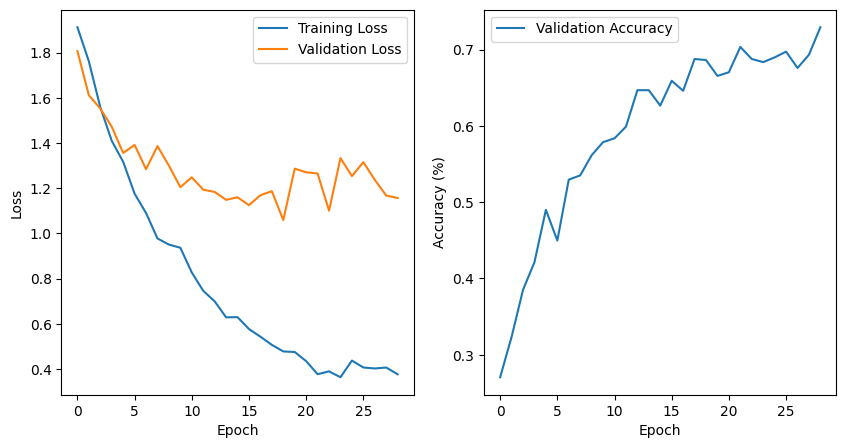

In [26]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## Test

In [27]:
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy in the test set: {accuracy:.2f}%")

Accuracy in the test set: 71.07%


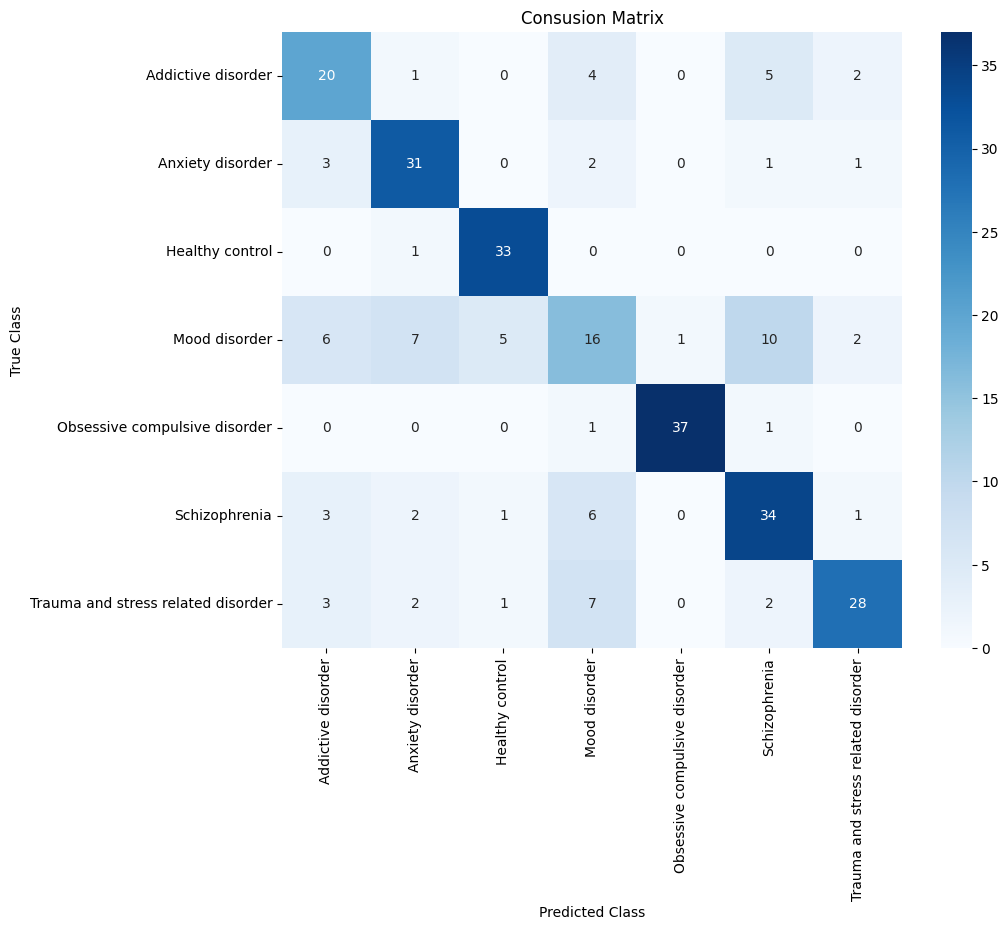

In [28]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Model outputs
            outputs = F.softmax(outputs, dim=1)  # Probs
            top_p, top_class = outputs.topk(k=1, dim=1)  # Pred class
            all_preds.extend(top_class.cpu().numpy())  # Preds
            all_labels.extend(labels.cpu().numpy())  # True class

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Consusion Matrix')
    plt.show()


plot_confusion_matrix(model, test_loader, column_names)

In [29]:
def evaluate(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs) 
            _, predicted = torch.max(outputs, 1)  
            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, digits=4)  
    print(report)

evaluate(model, test_loader)

              precision    recall  f1-score   support

           0     0.5714    0.6250    0.5970        32
           1     0.7045    0.8158    0.7561        38
           2     0.8250    0.9706    0.8919        34
           3     0.4444    0.3404    0.3855        47
           4     0.9737    0.9487    0.9610        39
           5     0.6415    0.7234    0.6800        47
           6     0.8235    0.6512    0.7273        43

    accuracy                         0.7107       280
   macro avg     0.7120    0.7250    0.7141       280
weighted avg     0.7055    0.7107    0.7036       280



In [30]:
def evaluate_auc(model, test_loader, num_classes):
    model.eval()  
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  
            
            probs = torch.softmax(outputs, dim=1)  
            all_preds.extend(probs.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    aucs = []
    for i in range(num_classes):
        auc = roc_auc_score(all_labels == i, all_preds[:, i])  
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    
    print(f"AUC por classe: {aucs}")
    print(f"AUC média: {mean_auc:.4f}")
    
    return aucs, mean_auc

aucs, mean_auc = evaluate_auc(model, test_loader, num_classes=7) 

AUC por classe: [0.8596270161290323, 0.929643323183993, 0.984337637494022, 0.7587434937448635, 0.9831897010320247, 0.8948954433385079, 0.9597684231184378]
AUC média: 0.9100


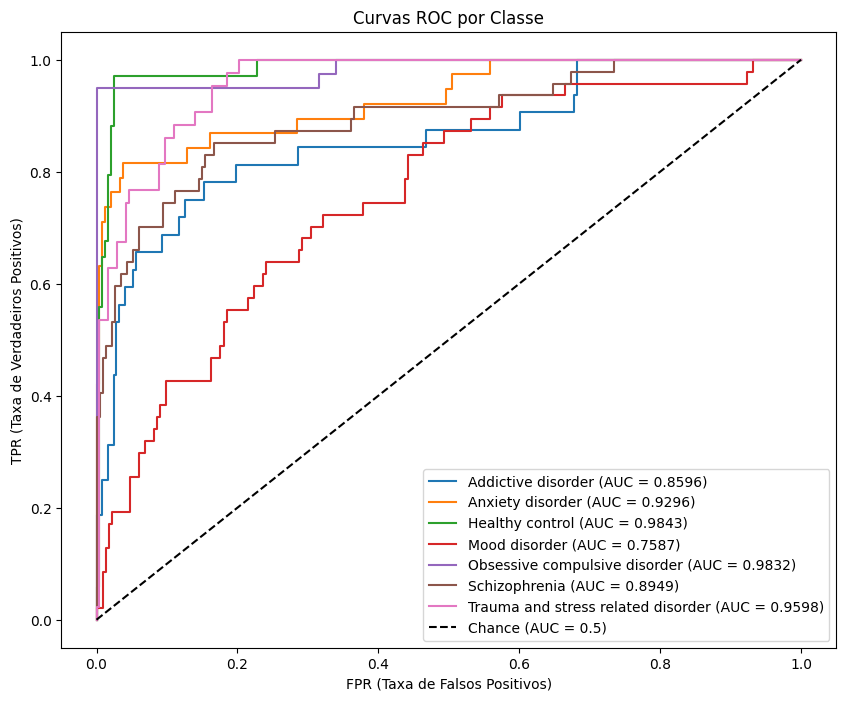

In [31]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
        auc = roc_auc_score(all_labels == i, all_preds[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

    plt.xlabel('FPR (Taxa de Falsos Positivos)')
    plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
    plt.title('Curvas ROC por Classe')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(model, test_loader, column_names)